In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from loop.dssp import generate_pdp_chain_pairs
from utils.common import load_tab, save_tab, dump_dicts2jsons, lower_pdbid, read_json2dict, dump_dict2json
from utils.protein import protein_letters_3to1

from utils.loops import print_loop_count

from domain_linker.cc_contact import contact, getCoords
from domain_linker.extract_linkers import get_2domain_start_end
from domain_linker.hbond import check_2Hbond
from params import *


# Functions

In [22]:
def clasify_interDomainLinker(df_domain_loops_dist, t_contact: int, t_hbond: int):
    '''
    classify domain-linkers from inter-domain loops. Between two domains:
    1. Num(C-C contact) < t_contact
    2. Num(Hbond) < t_hbond
    '''
    df_contact_t = df_domain_loops_dist[df_domain_loops_dist['num_contacts']<t_contact]
    df_independent = df_contact_t[df_contact_t['num_hbonds']<t_hbond]
    idx_independent = list(df_independent['linkerID'])
    idx_dependent = list(set(df_domain_loops_dist['linkerID']) - set(df_independent['linkerID']))
    df_dependent = df_domain_loops_dist[df_domain_loops_dist['linkerID'].isin(idx_dependent)]
    
    return df_independent, df_dependent, df_contact_t

In [23]:
def bin_count(df_independent, bins: list):
    loop_length = list(df_independent['length'])
    
    cls = [np.round(np.random.rand(),1), np.round(np.random.rand(),1),np.round(np.random.rand(),1), 0.8]
    print(cls)
    plt.figure(figsize=(12, 6))
    counts, edges, bars = plt.hist(loop_length, bins=bins, color=cls)
    
    return counts, loop_length, edges

# Generate domain_dataset table -- skippable

In [24]:
dict_domain_dataset = read_json2dict(path_domain_dataset)

In [25]:
df_domain_dataset = pd.DataFrame()

for domainID, d_info in dict_domain_dataset.items():
    df_domain = pd.json_normalize(d_info)
    pdb_chainid = d_info['pdb_chainid']
    df_domain['pdbid'] = pdb_chainid.split('_')[0].upper()
    df_domain['chain'] = pdb_chainid.split('_')[1].upper()
    df_domain['domain'] = domainID
    df_domain_dataset = pd.concat([df_domain_dataset, df_domain], axis=0, ignore_index=True)

In [26]:
df_domain_dataset.shape[0], len(df_domain_dataset['pdb_chainid'].unique())

(6059, 2649)

In [27]:
df_domain_dataset['seq'] = [' '.join(seq) for seq in df_domain_dataset['seq']]
df_domain_dataset['seq_unp'] = [' '.join(seq) for seq in df_domain_dataset['seq_unp']]

In [28]:
save_tab(df_domain_dataset, path_domain_dataset_tab)

# plots

## All-length Domains

In [35]:
df_domain_dataset = load_tab(path_domain_dataset_tab)
length =  df_domain_dataset['length']
max(length), min(length), df_domain_dataset.shape

(1542, 4, (6059, 18))

[np.float64(0.7), np.float64(0.9), np.float64(0.6), 0.8]


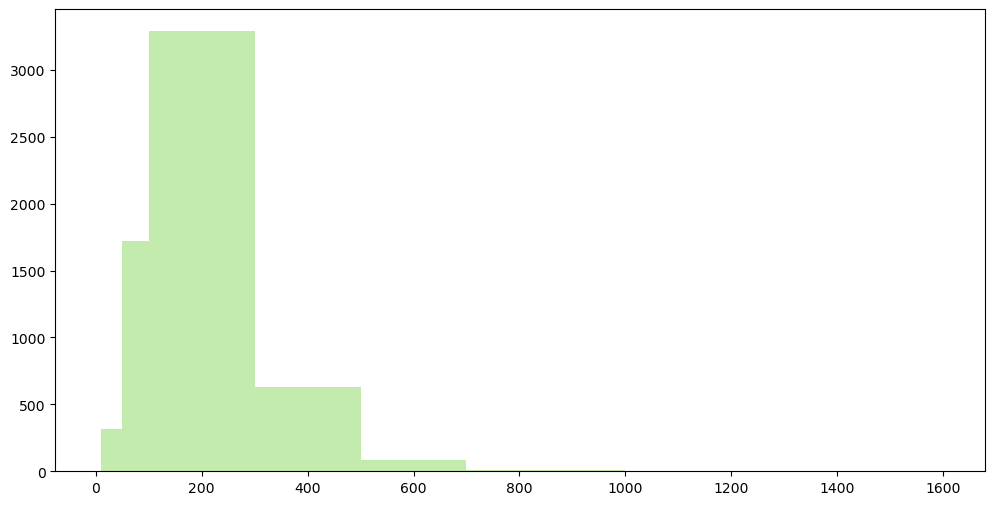

In [11]:
bins = [3, 10, 50, 100, 300, 500, 700, 1000, 1600]
counts_domain, length_domain, _ = bin_count(df_domain_dataset, bins)

Text(0, 0.5, 'Length of Domain')

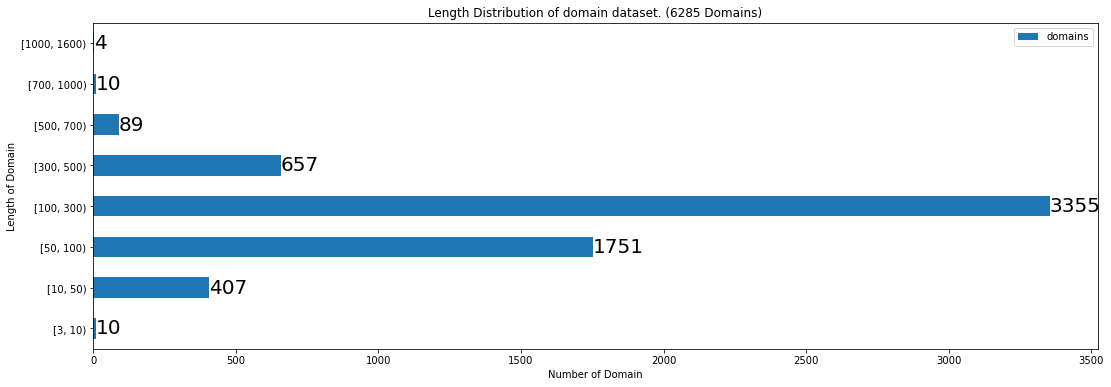

In [37]:
x = [u'[3, 10)', u'[10, 50)', u'[50, 100)', u'[100, 300)', u'[300, 500)', u'[500, 700)', u'[700, 1000)', u'[1000, 1600)']
y = counts_domain

# index = ['snail', 'pig', 'elephant','rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'domains': y})
df = df.set_axis(x)
ax = df.plot.barh(figsize=(18,6))
# ax.axhline(0, color='grey', linewidth=0.8)
ax.bar_label(ax.containers[0], fontsize=20)

ax.set_title('Length Distribution of domain dataset. (6285 Domains)')
ax.set_xlabel('Number of Domain')
ax.set_ylabel('Length of Domain')

## length: <10

In [35]:
df_domain_dataset[df_domain_dataset['length']<10].sort_values('length')

,pdb_chainid,start,end,start_unp,end_unp,unp_acc,dssp_key_str,length,miss_length,miss_percentage,missing,seq,seq_unp,seq_id,seq_id_unp,pdbid,chain,domain
5015,3zx8_a,169,171,169,171,P06663,"['A_169_ ', 'A_170_ ', 'A_171_ ']",3,0,0.0,"[0, 0, 0]",L Y N,L Y N,"[169, 170, 171]","[169, 170, 171]",3ZX8,A,8071987
6066,5x5f_a,660,662,660,662,K9N5Q8,"['A_660_ ', 'A_661_ ', 'A_662_ ']",3,0,0.0,"[0, 0, 0]",S V I,S V I,"[660, 661, 662]","[660, 661, 662]",5X5F,A,8092666
3571,2fo1_e,938,941,938,941,P14585,"['E_938_ ', 'E_939_ ', 'E_940_ ', 'E_941_ ']",4,0,0.0,"[0, 0, 0, 0]",R X I N,R M I N,"[938, 939, 940, 941]","[938, 939, 940, 941]",2FO1,E,8004162
1066,1j2o_a,57,63,81,87,P25801,"['A_57_ ', 'A_58_ ', 'A_59_ ', 'A_60_ ', 'A_61...",7,0,0.0,"[0, 0, 0, 0, 0, 0, 0]",R R D Y L R L,R R D Y L R L,"[57, 58, 59, 60, 61, 62, 63]","[81, 82, 83, 84, 85, 86, 87]",1J2O,A,8019848
4363,3b2u_a,496,502,520,526,P00533,"['A_496_ ', 'A_497_ ', 'A_498_ ', 'A_499_ ', '...",7,0,0.0,"[0, 0, 0, 0, 0, 0, 0]",P R D C V S C,P R D C V S C,"[496, 497, 498, 499, 500, 501, 502]","[520, 521, 522, 523, 524, 525, 526]",3B2U,A,8026384
4916,3ttc_a,110,116,110,116,A0A0H3JHT3,"['A_110_ ', 'A_111_ ', 'A_112_ ', 'A_113_ ', '...",7,0,0.0,"[0, 0, 0, 0, 0, 0, 0]",P A C L A E M,P A C L A E M,"[110, 111, 112, 113, 114, 115, 116]","[110, 111, 112, 113, 114, 115, 116]",3TTC,A,8092439
5217,4g9i_a,110,116,110,116,Q5JII4,"['A_110_ ', 'A_111_ ', 'A_112_ ', 'A_113_ ', '...",7,0,0.0,"[0, 0, 0, 0, 0, 0, 0]",D D C L R E L,D D C L R E L,"[110, 111, 112, 113, 114, 115, 116]","[110, 111, 112, 113, 114, 115, 116]",4G9I,A,8092447
2466,1ubd_c,401,408,401,408,P25490,"['C_401_ ', 'C_402_ ', 'C_403_ ', 'C_404_ ', '...",8,0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0]",K S H I L T H A,K S H I L T H A,"[401, 402, 403, 404, 405, 406, 407, 408]","[401, 402, 403, 404, 405, 406, 407, 408]",1UBD,C,8026602
5218,4g9i_a,160,167,160,167,Q5JII4,"['A_160_ ', 'A_161_ ', 'A_162_ ', 'A_163_ ', '...",8,0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0]",D F C R S E Y E,D F C R S E Y E,"[160, 161, 162, 163, 164, 165, 166, 167]","[160, 161, 162, 163, 164, 165, 166, 167]",4G9I,A,8092448
5505,4qft_a,200,208,200,208,Q7L5N1,"['A_200_ ', 'A_201_ ', 'A_202_ ', 'A_203_ ', '...",9,0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",V D H V A R M T A,V D H V A R M T A,"[200, 201, 202, 203, 204, 205, 206, 207, 208]","[200, 201, 202, 203, 204, 205, 206, 207, 208]",4QFT,A,8048103


In [23]:
df_domain_dataset[df_domain_dataset['pdb_chainid']=='3ksy_a']
df_domain_dataset.shape

(6280, 18)

# Load DLD regions

### 0. Domain

In [2]:
df_domain_dataset = load_tab(path_domain_dataset_tab)
df_domain_short = df_domain_dataset[df_domain_dataset['length']<30]
short_domain_list = [s.upper() for s in df_domain_short['pdb_chainid']]

In [3]:
save_tab(df_domain_short, 'domain_short.tsv')

In [10]:
len(df_domain_short[df_domain_short['length']<20]['pdb_chainid'].unique())

24

### 1. intra-domain Loops

In [3]:
df_intra_domain_loop = load_tab(path_loops_intra_domain_smoothSS_first_2step_tab)

### 2. independent-domain-linker

In [4]:
df_independent_domain_linker = load_tab(path_independent_domain_linker)
df_independent_domain_linker.shape, df_independent_domain_linker.columns

((1647, 31),
 Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
        'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
        'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
        'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
        'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
        'start_domain', 'end_domain', 'dist', 'missing_domain', 'pdb_chainid',
        'seqID'],
       dtype='object'))

In [5]:
df_independent_domain_linker[df_independent_domain_linker['miss_length']>0].shape

(154, 31)

### 3. dependent-domain-linker

In [6]:
df_dependent_domain_linker = load_tab(path_dependent_domain_linker)
df_dependent_domain_linker.shape, df_dependent_domain_linker.columns

((649, 31),
 Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
        'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
        'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
        'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
        'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
        'start_domain', 'end_domain', 'dist', 'missing_domain', 'pdb_chainid',
        'seqID'],
       dtype='object'))

### 4. T

In [7]:
df_terminus = load_tab(path_terminus_tab)

In [39]:
len(df_domain_dataset['pdb_chainid'].unique())

2649

In [40]:
df_intra_domain_loop.shape

(44977, 17)

In [41]:
df_intra_domain_loop['pdb_chainid'] = [f"{r['pdbid']}_{r['chain']}" for _, r in df_intra_domain_loop.iterrows()]

In [42]:
len(df_intra_domain_loop['pdb_chainid'].unique())

2649

In [43]:

df_dependent_domain_linker['pdb_chainid'] = [f"{r['pdbid_domain']}_{r['chainid_domain']}" for _, r in df_dependent_domain_linker.iterrows()]
len(df_dependent_domain_linker['pdb_chainid'].unique())

620

In [44]:
df_terminus
df_terminus['pdb_chainid'] = [f"{r['pdbid']}_{r['chain']}" for _, r in df_terminus.iterrows()]
len(df_terminus['pdb_chainid'].unique())

1753

In [45]:
df_terminus.shape

(2994, 21)

In [46]:

df_independent_domain_linker['pdb_chainid'] = [f"{r['pdbid_domain']}_{r['chainid_domain']}" for _, r in df_independent_domain_linker.iterrows()]
len(df_independent_domain_linker['pdb_chainid'].unique())

1408

In [48]:
df_independent_domain_linker.shape

(1647, 30)

In [49]:
df_independent_domain_linker[df_independent_domain_linker['length']>=10].shape

(920, 30)

In [50]:
df_test = df_terminus[df_terminus['pidChainUnp']=='1aqt_a_P0A6E6']
df_test[df_test['length']<4]

# df_terminus[df_terminus['length']<4]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,...,miss_percentage,unp_acc,length,terminu,pdbid,chain,pidChainUnp,id,len_seq_unp,pdb_chainid


In [52]:
df_intra_domain_loop[df_intra_domain_loop['length']<4]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,domain,pdbid,chain,pdb_chainid


# Add seqID columns to the two domain linker files (for the website)

In [53]:
df_independent_domain_linker.columns

Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
       'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
       'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
       'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
       'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
       'start_domain', 'end_domain', 'dist', 'missing_domain', 'pdb_chainid'],
      dtype='object')

In [54]:
df_independent_domain_linker[['pdbid_domain', 'chainid_domain', 'unp_acc']]

df_independent_domain_linker['seqID'] = [f"{r['pdbid_domain'].lower()}_{r['chainid_domain'].lower()}_{r['unp_acc']}" for _, r in df_independent_domain_linker.iterrows()]
df_dependent_domain_linker['seqID'] = [f"{r['pdbid_domain'].lower()}_{r['chainid_domain'].lower()}_{r['unp_acc']}" for _, r in df_dependent_domain_linker.iterrows()]

In [55]:
df_independent_domain_linker.shape, df_dependent_domain_linker.shape

((1647, 31), (649, 31))

In [56]:
save_tab(df_dependent_domain_linker, path_dependent_domain_linker)
save_tab(df_independent_domain_linker, path_independent_domain_linker)

# Update DLD regions by excluding short domains

In [19]:
# 1. Load the 5 datasets.
# 1.1. domain
df_domain_dataset = load_tab(path_domain_dataset_tab)

# 1.2. intra-domain-loop
df_intra_domain_loop = load_tab(path_loops_intra_domain_smoothSS_first_2step_tab)

# 1.3. dependent-domain-linker
df_dependent_domain_linker = load_tab(path_dependent_domain_linker)

# 1.4. independent-domain-linker
df_independent_domain_linker = load_tab(path_independent_domain_linker)

# 1.4. terminus
df_terminus = load_tab(path_terminus_tab)

df_intra_domain_loop['pdb_chainid'] = [f"{r['pdbid']}_{r['chain']}" for _, r in df_intra_domain_loop.iterrows()]
df_terminus['pdb_chainid'] = [f"{r['pdbid']}_{r['chain']}" for _, r in df_terminus.iterrows()]

df_domain_short = df_domain_dataset[df_domain_dataset['length']<10]
short_domain_list_lower = list(df_domain_short['pdb_chainid'].unique())
short_domain_list = [s.upper() for s in short_domain_list_lower]
short_domain_list_lower, short_domain_list

(['1e3h_a', '3ttc_a', '4g9i_a'], ['1E3H_A', '3TTC_A', '4G9I_A'])

In [ ]:
df_domain_dataset.shape, df_intra_domain_loop.shape, df_dependent_domain_linker.shape, df_independent_domain_linker.shape, df_terminus.shape

((6059, 18), (44977, 18), (649, 31), (1647, 31), (2994, 21))

In [25]:
df_domain_dataset = df_domain_dataset[~df_domain_dataset['pdb_chainid'].isin(short_domain_list_lower)]
df_intra_domain_loop = df_intra_domain_loop[~df_intra_domain_loop['pdb_chainid'].isin(short_domain_list)]
df_dependent_domain_linker = df_dependent_domain_linker[~df_dependent_domain_linker['pdb_chainid'].isin(short_domain_list)]
df_independent_domain_linker = df_independent_domain_linker[~df_independent_domain_linker['pdb_chainid'].isin(short_domain_list)]
df_terminus = df_terminus[~df_terminus['pdb_chainid'].isin(short_domain_list)]

In [26]:
df_domain_dataset.shape, df_intra_domain_loop.shape, df_dependent_domain_linker.shape, df_independent_domain_linker.shape, df_terminus.shape

((6044, 18), (44896, 18), (647, 31), (1640, 31), (2991, 21))

In [31]:
len(df_domain_dataset['pdb_chainid'].unique())

2646

In [29]:
min(df_intra_domain_loop['length']), min(df_domain_dataset['length']), min(df_terminus['length']), min(df_dependent_domain_linker['length']), min(df_independent_domain_linker['length'])

(4, 10, 4, 4, 4)

In [27]:
# 1. Load the 5 datasets.
# 1.1. domain
save_tab(df_domain_dataset, path_domain_dataset_tab)

# 1.2. intra-domain-loop
save_tab(df_intra_domain_loop, path_loops_intra_domain_smoothSS_first_2step_tab)

# 1.3. dependent-domain-linker
save_tab(df_dependent_domain_linker, path_dependent_domain_linker)

# 1.4. independent-domain-linker
save_tab(df_independent_domain_linker, path_independent_domain_linker)

# 1.4. terminus
save_tab(df_terminus, path_terminus_tab)

# save to distionary

In [ ]:
path_loops_intra_domain_smoothSS_first_2step, path_domain_dataset, path_terminus, 

In [30]:
dump_dict2json(df_independent_domain_linker.to_dict(orient='records'), path_independent_domain_linker_json)
dump_dict2json(df_dependent_domain_linker.to_dict(orient='records'), path_dependent_domain_linker_json)

dump_dict2json(df_intra_domain_loop.to_dict(orient='records'), path_loops_intra_domain_smoothSS_first_2step)
dump_dict2json(df_domain_dataset.to_dict(orient='records'), path_domain_dataset)

dump_dict2json(df_terminus.to_dict(orient='records'), path_terminus)

# update two meta files

In [38]:
multi_domain = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian)
dict_pdb_chain_unp = read_json2dict(path_pdb_chain_unp)
multi_domain['pdb_chainid'] = [r.lower() for r in multi_domain['seq_id']]
# dump_dict2json(dict_pdb_chain_unp, path_pdb_chain_unp)

In [40]:
multi_domain[:2]

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,FA,FA-UNIREG-START,FA-UNIREG-END,FA-PDBREG-START,FA-PDBREG-END,FA-CHAINID,seq_id,length,experiment_type,resolution,pdb_chainid
0,8024262,1A04,A:150-216,P0AF28,150-216,4000720,150,216,150,216,A,1a04_A,67,XRay,2.2,1a04_a
1,8031657,1A04,A:5-142,P0AF28,5-142,4003632,5,142,5,142,A,1a04_A,138,XRay,2.2,1a04_a


In [43]:
multi_domain = multi_domain[multi_domain['pdb_chainid'].isin(list(df_domain_dataset['pdb_chainid'].unique()))]
len(multi_domain['pdb_chainid'].unique())

2646

In [44]:
print('Update path_pdb_chain_unp')
dict_pdb_chain_unp = {}
df_dict = multi_domain[['FA-PDBID', 'FA-CHAINID', 'FA-UNIID']]
for pdbid, sub_df in df_dict.groupby("FA-PDBID"):
    pdbid_lower = pdbid.lower()
    chain_dict = {}
    for chain_id, chain_df in sub_df.groupby("FA-CHAINID"):
        unique_uniprot = sorted(set(chain_df["FA-UNIID"]))  # remove duplicates
        chain_dict[chain_id] = unique_uniprot
    dict_pdb_chain_unp[pdbid_lower] = chain_dict

Update path_pdb_chain_unp


In [46]:
dump_dict2json(dict_pdb_chain_unp, path_pdb_chain_unp)